In [9]:
%pylab inline
import gc
import matplotlib
import scipy
import fitsio

cmap=plt.get_cmap('tab20')

import hmf
import haloSim
import catSimutil as simutil
import astropy.table as astTable
from cosmology import Cosmo
cosmo   =   Cosmo(h=1.,omega_m=0.315)

from configparser import ConfigParser
from pixel3D import cartesianGrid3D

Populating the interactive namespace from numpy and matplotlib


In [10]:
pend0='obs-nl12'
pend='m146_152' 
configName  =   'wrkDir/sim/planck-cosmo/config-%s-pc.ini' %pend0
parser      =   ConfigParser()
parser.read(configName)
gridInfo    =   cartesianGrid3D(parser)
lensKer0=gridInfo.lensing_kernel(deltaIn=False)
lensKer1=gridInfo.lensing_kernel(deltaIn=True)
zbound=gridInfo.zlbound
zave=gridInfo.zlcgrid

parser2      =   ConfigParser()
parser2.read(configName)
parser2.set('sourceZ','zbound','[0.02,10]')
cg=cartesianGrid3D(parser2)
print(cg.xcgrid[24])

-1.6653345369377348e-16


In [11]:
# Initialize hmf
hmfmod='Tinker08'#'ST'#
#pend='m140_146'
mmin=eval(pend[1:].split('_')[0])/10.
mmax=eval(pend[1:].split('_')[1])/10.
mf = hmf.MassFunction(Mmin=mmin,Mmax=mmax,dlog10m=0.008,hmf_model=hmfmod,takahashi=True,sigma_8=0.811,n=0.965)

mf.update(cosmo_params={"Om0":0.315,"H0":67.4})
print(mf.cosmo)
print(mf.hmf_model)
# galaxy catalog for positions
infname='wrkDir/sim/HSC-obs/20200328/stampSim_HSClike_mask_shapenoise_photoz-202003282257.fits'
data=astTable.Table.read(infname)
print('number of loaded noise: %d' %len(data))
ng=len(data)//100
dataU=data[:ng]

FlatLambdaCDM(name="Planck15", H0=67.4 km / (Mpc s), Om0=0.315, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)
<class 'hmf.mass_function.fitting_functions.Tinker08'>
number of loaded noise: 8257800


4.814513680401408 3.948180957329429 524169236263257.25
56.28206216411832
3.181086666264528 3.9181649417387394 523859203563715.2
25.108006995931685
2.4372279532525085 3.886784666550186 527776644719732.5
15.002326733489323
1.9940723455008273 3.865320778894166 523473559063654.5
10.401587271528742
1.7066354362382936 3.8439296574740243 520198014648001.7
7.894114911115188
1.5068973690815053 3.8215961663592006 518792303430754.1
6.359595805219475
1.3460260026251238 3.8087754986559936 506364801521594.5
5.3424597895237955
1.223222899580694 3.793935098961654 494704136875274.7
4.62680044010488
1.150101584307642 3.761346576541537 512497745586303.5
4.106245035840618
1.068639995983402 3.747705360141482 503120079515348.2
3.72160167988598
0.9994829511954277 3.736270063669426 493819678797470.4
3.42111417323345
0.9470742307562776 3.7185171767892586 491514752989517.06
3.1863367198091717


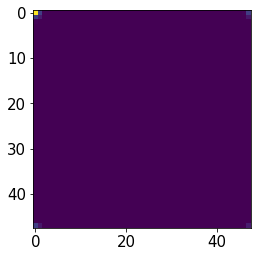

In [31]:
#Prepare basis vectors
ngrid=48
nn=500

outDir='wrkDir/sim/planck-cosmo/prior/'
haloAveAll=np.zeros((gridInfo.nzl,1,ngrid,ngrid))
for iz in range(0,gridInfo.nzl):
    z=zave[iz]
    pix2mpc=cosmo.Da(0.,z)*1./60./180*np.pi #[Mpc/h]
    mf.update(z=z)
    m = mf.m
    v=cosmo.V(zbound[iz],zbound[iz+1])*np.pi**2./180.**2./4./np.pi
    mass_func = mf.dndm*v
    imgList=np.empty((nn,ngrid,ngrid))
    rsAve=0.
    concAve=0.
    mAve=0.
    for i in range(nn):
        # randomly sampe a mass
        mi=simutil.mcSample(m,mass_func)[0]
        conc =  6.02*(mi/1.E13)**(-0.12)*(1.47/(1.+z))**(0.16)
        concAve+=conc
        rs_arcmin=haloSim.mc2rs(mi,conc,z)
        rsAve+=rs_arcmin
        mAve+=mi
    rsAve=rsAve/nn
    concAve=concAve/nn
    mAve=mAve/nn
    print(rsAve,concAve,mAve)
    #print(pix2mpc**2.)
    halo=haloSim.nfw_lensTJ03(mass=mAve,conc=concAve,redshift=z,ra=0.,dec=0.)
    SigmaArray  =   halo.Sigma(dataU['raR']*3600.,dataU['decR']*3600.)
    pixSigma=np.fft.ifftshift(cg.pixelize_data(dataU['raR'],dataU['decR'],None,SigmaArray)[0]/mAve)
    plt.imshow(pixSigma)
    haloAveAll[iz,0]=pixSigma
    print(np.sum(pixSigma))
    del pixSigma,rsAve,concAve,mAve,SigmaArray
    gc.collect()
pyfits.writeto(os.path.join(outDir,'haloBasis-%s-%s.fits' %(pend0,pend)),haloAveAll,overwrite=True)

4.8857442793387476 3.932161748216731 539985613375286.2
1.010268172737529
3.1746262716891254 3.919811272527593 520834657825218.1
1.0143868866134313
2.4216500292379215 3.893101871134283 520224795496779.75
1.0189902367031831
1.989594293299571 3.8668211014831155 519833061626981.2
1.0234835857652596
1.7121517020094583 3.84110581853836 524494878700298.56
1.0285512593080433
1.500152017962467 3.8253778926773774 512494004134092.5
1.0340138907636096
1.3480466200927588 3.80676524944662 507058766134459.06
1.03824470670282
1.2281825785117764 3.7902478380712057 499662403947184.9
1.0412417451496097
1.1441256910618922 3.7668224676805875 507209090729603.8
1.0449755684075233
1.0733586919158111 3.7438070111527573 508626694374341.06
1.0496297131697272
1.0069042897929363 3.7289362300338365 501696775891348.5
1.0531469209972275
0.9446697381105692 3.7205687452449405 488221176886352.8
1.0579543546894679


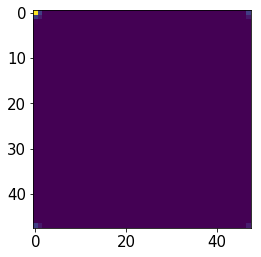

In [30]:
#Prepare basis vectors
ngrid=48
nn=500

outDir='wrkDir/sim/planck-cosmo/prior/'
haloAveAll=np.zeros((gridInfo.nzl,1,ngrid,ngrid))
for iz in range(0,gridInfo.nzl):
    z=zave[iz]
    pix2mpc=cosmo.Da(0.,z)*1./60./180*np.pi #[Mpc/h]
    mf.update(z=z)
    m = mf.m
    v=cosmo.V(zbound[iz],zbound[iz+1])*np.pi**2./180.**2./4./np.pi
    mass_func = mf.dndm*v
    imgList=np.empty((nn,ngrid,ngrid))
    rsAve=0.
    concAve=0.
    mAve=0.
    for i in range(nn):
        # randomly sampe a mass
        mi=simutil.mcSample(m,mass_func)[0]
        conc =  6.02*(mi/1.E13)**(-0.12)*(1.47/(1.+z))**(0.16)
        concAve+=conc
        rs_arcmin=haloSim.mc2rs(mi,conc,z)
        rsAve+=rs_arcmin
        mAve+=mi
    rsAve=rsAve/nn
    concAve=concAve/nn
    mAve=mAve/nn
    print(rsAve,concAve,mAve)
    #print(pix2mpc**2.)
    halo=haloSim.nfw_lensTJ03(mass=mAve,conc=concAve,redshift=z,ra=0.,dec=0.)
    SigmaArray  =   halo.Sigma(dataU['raR']*3600.,dataU['decR']*3600.)
    pixSigma=np.fft.ifftshift(cg.pixelize_data(dataU['raR'],dataU['decR'],None,SigmaArray)[0]/mAve)
    plt.imshow(pixSigma)
    haloAveAll[iz,0]=pixSigma
    dx=halo.DaLens*gridInfo.delta*np.pi/180.
    print(np.sum(pixSigma)*dx**2.)
    del pixSigma,rsAve,concAve,mAve,SigmaArray
    gc.collect()
pyfits.writeto(os.path.join(outDir,'haloBasis-%s-%s.fits' %(pend0,pend)),haloAveAll,overwrite=True)

In [27]:
halo.Sigma(dataU['raR']*3600.,dataU['decR']*3600.).max()

3402822611551685.5

In [26]:
dataU['raR']

0.1252543890422696
0.011568174451773383
-0.09315804494109214
-0.3885442758185812
-0.3142861773001051
-0.4186927188941735
0.1279425320787032
-0.3159218262417991
0.044485093385245866
-0.4699203317240983
0.2265010760228321


0.576163829317587

Help on float object:

class float(object)
 |  float(x=0, /)
 |  
 |  Convert a string or number to a floating point number, if possible.
 |  
 |  Methods defined here:
 |  
 |  __abs__(self, /)
 |      abs(self)
 |  
 |  __add__(self, value, /)
 |      Return self+value.
 |  
 |  __bool__(self, /)
 |      self != 0
 |  
 |  __divmod__(self, value, /)
 |      Return divmod(self, value).
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __float__(self, /)
 |      float(self)
 |  
 |  __floordiv__(self, value, /)
 |      Return self//value.
 |  
 |  __format__(self, format_spec, /)
 |      Formats the float according to format_spec.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getnewargs__(self, /)
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __hash__(self, /)
 |      Return hash(self).
 |  
 |  __int__(self, /)
 |      int(self)
 |  
 |  __le__

In [20]:
gridInfo.delta*60

2.0

In [ ]:
        selfnorm2=np.sqrt(np.sum(imgList**2,axis=(1,2)))
        haloAve=np.average(imgList,axis=0)
        #norm=np.sqrt(np.sum(haloAve**2.))
        norm=np.sum(haloAve)*pix2mpc**2.
        # normalize to make sure \int dxdy f(x,y)=1
        haloAve=haloAve/norm
    mask=haloAveAll>1e-5
    haloAveAll[~mask]=0.
    print(np.min(haloAveAll))
    pyfits.writeto(os.path.join(outDir,'haloBasis-nl10.fits'),haloAveAll,overwrite=True)